In [176]:
import pandas as pd
import numpy as np
import os


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

In [177]:
main_datasets = ["BACE_class", "BACE_regre", "ROR_class", "ROR_regre"]
top5 = {}

best_models = {}
best_models_avg_top = pd.DataFrame(columns=["dataset", "model", "split", "avg_top_score"])
best_models_preproessing_avg_top = pd.DataFrame(columns=["dataset", "model", "split", "avg_top_score"])
avg_top_count = 5
best_models_split = {}
hyperparameter_rank = {}
top_models_evaluated = 25

In [178]:
for dataset in main_datasets:
    if dataset.split("_")[1] == "class":
        task = "classification"
    else:
        task = "regression"

    df = pd.read_csv(r"Merged runs/" + dataset + ".csv")
    #print(df.columns)

    regre = False
    score_column = "roc_auc"
    if dataset[-5:] == "regre": 
        regre = True
        score_column = "mse"

    df.sort_values(score_column, ascending=regre, inplace=True)

    top5[dataset] = df.head(5)

    for model in df['model'].unique():
        right_model = df[df['model'] == model]

        for split in df['split'].unique():
            best_configs = right_model[df['split'] == split].head(top_models_evaluated)
            best_configs_hyperparams = best_configs[['hyperparams']]
            ### Avg top scores per model
            avg_top = best_configs.head(avg_top_count).loc[:, score_column].mean()
            best_models_avg_top.loc[len(best_models_avg_top.index)] = [dataset, model, split, avg_top]

            ### Top parameters frequency
            if not dataset in hyperparameter_rank.keys():
                hyperparameter_rank[dataset] = {}

            if not model in hyperparameter_rank[dataset].keys():
                hyperparameter_rank[dataset][model] = {}
            
            for index, row in best_configs_hyperparams.iterrows():
                params = list(row)[0][1:-1].split(", ")
                for param in params:
                    if param == "": continue
                    if not param in hyperparameter_rank[dataset][model].keys():
                        hyperparameter_rank[dataset][model][param] = 1
                    else:
                        hyperparameter_rank[dataset][model][param] += 1

    best_models_avg_top.sort_values(['dataset', 'model', 'split'], inplace=True)


    ### For each model, get 5 best configurations
        ### each parameter value from the configuration gets +1 in representation dict
        ### like {'LogisticRegression': {'solver: liblinear': x+1}}
    
    ### Separate on bace and ROR?


    best = {}
    for index, row in df.iterrows():
        if len(best) >= 7:
            break
        if not row['model'] in best.keys():
            best[row['model']] = [row[score_column], row['hyperparams']]

    best_models[dataset] = best
    
    df_temp = df.drop_duplicates(subset=['model', 'split'])

    df_temp.sort_values(['model', 'split'], inplace=True)

    df_temp = df_temp[['model', 'split', score_column]]


    ### New after revision:

    #ROR_size = 2186
    #BACE_size = 1513
    #if dataset.split("_")[0] == "BACE":
    #    df_temp['split'] = df_temp['split'].apply(lambda x: float(x)*BACE_size)
    #else:
    #    df_temp['split'] = df_temp['split'].apply(lambda x: float(x)*ROR_size)

    best_models_split[dataset] = df_temp

C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\1989749225.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_configs = right_model[df['split'] == split].head(top_models_evaluated)
C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\1989749225.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_configs = right_model[df['split'] == split].head(top_models_evaluated)
C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\1989749225.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_configs = right_model[df['split'] == split].head(top_models_evaluated)
C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\1989749225.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_configs = right_model[df['split'] == split].head(top_models_evaluated)
C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\1989749225.py:24: UserWarning: Boolean Series key will be rein

### Top 5 scores on a dataset

In [179]:
top5[main_datasets[0]]

,Unnamed: 0,model,hyperparams,roc_auc,train_roc_auc,accuracy,train_accuracy,precision,train_precision,recall,train_recall,f1,train_f1,split,preprocessing
0,0,SVC,"{'C': 0.01, 'kernel': 'poly', 'gamma': 0.05}",0.880874,0.873432,0.881579,0.872153,0.887324,0.832268,0.863014,0.883051,0.875000,0.856908,0.9,Descriptors
1,1,SVC,"{'C': 1, 'kernel': 'rbf', 'gamma': 0.05}",0.867696,0.887544,0.868421,0.886113,0.873239,0.848000,0.849315,0.898305,0.861111,0.872428,0.9,Descriptors
2,2,LogisticRegression,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.861366,0.956064,0.861842,0.955180,0.861111,0.935750,0.849315,0.962712,0.855172,0.949039,0.9,Fingerprints
3,3,LogisticRegression,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}",0.861366,0.956912,0.861842,0.955915,0.861111,0.935855,0.849315,0.964407,0.855172,0.949917,0.9,Fingerprints
4,4,SVC,"{'C': 10, 'kernel': 'rbf', 'gamma': 'scale'}",0.860846,0.907043,0.861842,0.905952,0.871429,0.873786,0.835616,0.915254,0.853147,0.894040,0.9,Descriptors


### Best performance of each model on the dataset

In [180]:
best_models[main_datasets[0]]

{'SVC': [0.8808739379226634, "{'C': 0.01, 'kernel': 'poly', 'gamma': 0.05}"],
 'LogisticRegression': [0.8613663950060689,
  "{'C': 1, 'penalty': 'l2', 'solver': 'saga'}"],
 'RandomForestClassifier': [0.860325992717184,
  "{'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0, 'n_estimators': 100}"],
 'MLPClassifier': [0.8587944399893076,
  "{'hidden_layer_sizes': (50,), 'activation': 'logistic', 'alpha': 0.01, 'max_iter': 1000, 'solver': 'adam'}"],
 'XGBClassifier': [0.8555574822264608,
  "{'max_depth': 7, 'eta': 0.1, 'gamma': 0}"],
 'GradientBoostingClassifier': [0.8534766776486908,
  "{'max_depth': 5, 'loss': 'exponential', 'n_estimators': 10, 'learning_rate': 0.5, 'min_impurity_decrease': 0.1}"],
 'DecisionTreeClassifier': [0.8374097834803528,
  "{'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0, 'criterion': 'log_loss', 'splitter': 'best'}"]}

In [181]:
best_models[main_datasets[2]]

{'XGBClassifier': [0.7635924796747966,
  "{'max_depth': 5, 'eta': 0.1, 'gamma': 0.1}"],
 'MLPClassifier': [0.7588922764227641,
  "{'hidden_layer_sizes': (100,), 'activation': 'relu', 'alpha': 0.01, 'max_iter': 200, 'solver': 'adam'}"],
 'GradientBoostingClassifier': [0.7566056910569107,
  "{'max_depth': 3, 'loss': 'log_loss', 'n_estimators': 100, 'learning_rate': 0.5, 'min_impurity_decrease': 0.2}"],
 'LogisticRegression': [0.7486026422764227,
  "{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}"],
 'DecisionTreeClassifier': [0.7484756097560976,
  "{'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'min_impurity_decrease': 0, 'criterion': 'gini', 'splitter': 'best'}"],
 'RandomForestClassifier': [0.7479674796747967,
  "{'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0, 'n_estimators': 50}"],
 'SVC': [0.7473323170731707, "{'C': 10, 'kernel': 'poly', 'gamma': 0.05}"]}

In [182]:
best_models[main_datasets[1]]

{'SVR': [0.3558742601956201,
  "{'C': 1, 'kernel': 'rbf', 'epsilon': 0.01, 'gamma': 'scale'}"],
 'MLPRegressor': [0.4207656337225368,
  "{'hidden_layer_sizes': (50,), 'activation': 'tanh', 'alpha': 0.01, 'max_iter': 1000, 'solver': 'sgd'}"],
 'GradientBoostingRegressor': [0.4295687802008546,
  "{'max_depth': 3, 'loss': 'squared_error', 'n_estimators': 200, 'learning_rate': 0.1, 'min_impurity_decrease': 0}"],
 'XGBRegressor': [0.4351372608071586,
  "{'max_depth': 3, 'eta': 0.2, 'gamma': 0.1}"],
 'RandomForestRegressor': [0.4886696185113259,
  "{'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0, 'n_estimators': 100}"],
 'DecisionTreeRegressor': [0.5852374568905848,
  "{'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 0, 'splitter': 'random', 'criterion': 'poisson'}"],
 'LinearRegression': [1.073240982224002, '{}']}

In [183]:
best_models[main_datasets[3]]

{'GradientBoostingRegressor': [0.4002603603831062,
  "{'max_depth': 7, 'loss': 'huber', 'n_estimators': 100, 'learning_rate': 0.1, 'min_impurity_decrease': 0.1}"],
 'RandomForestRegressor': [0.4032060640705749,
  "{'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'min_impurity_decrease': 0, 'n_estimators': 100}"],
 'XGBRegressor': [0.4103324774251538,
  "{'max_depth': None, 'eta': 0.1, 'gamma': 0}"],
 'SVR': [0.4144492845381169,
  "{'C': 0.01, 'kernel': 'poly', 'epsilon': 0.1, 'gamma': 0.1}"],
 'MLPRegressor': [0.4497252056852791,
  "{'hidden_layer_sizes': (100,), 'activation': 'logistic', 'alpha': 0.001, 'max_iter': 1000, 'solver': 'sgd'}"],
 'DecisionTreeRegressor': [0.5566470912087783,
  "{'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 0, 'splitter': 'random', 'criterion': 'absolute_error'}"],
 'LinearRegression': [8.196392097841139, '{}']}

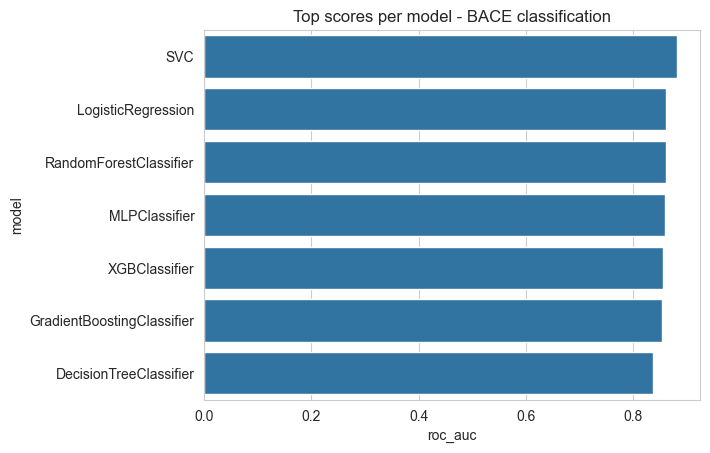

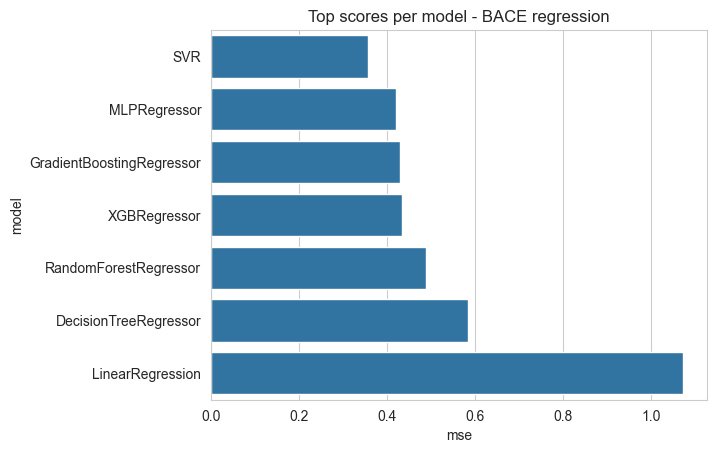

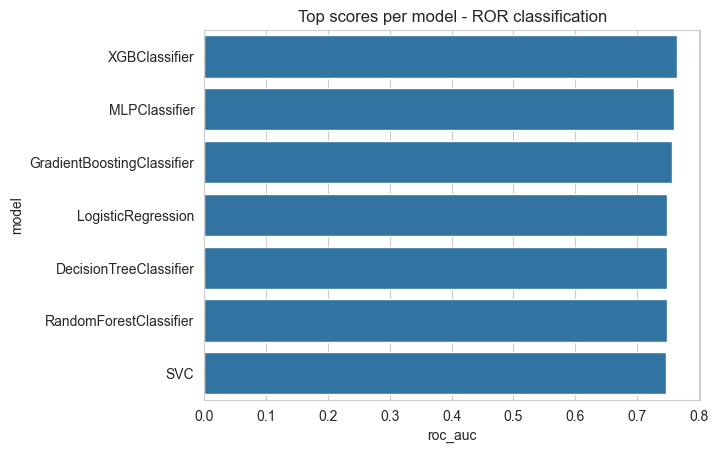

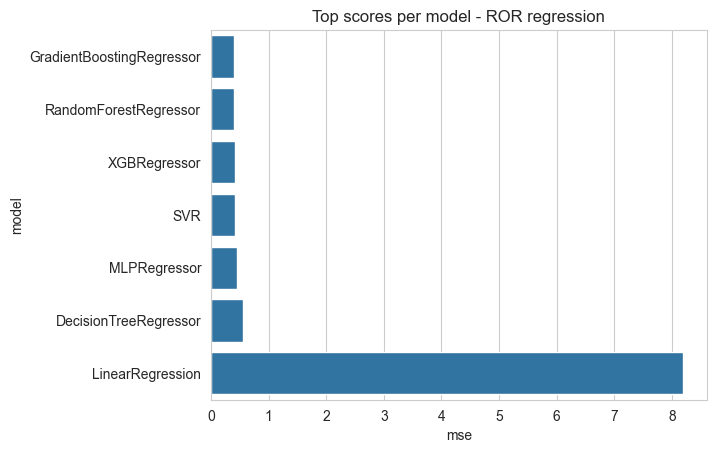

<Figure size 640x480 with 0 Axes>

In [184]:
for dataset in main_datasets:
    if dataset.split("_")[1] == "class":
        task = "classification"
        score = "roc_auc"
    else:
        task = "regression"
        score = "mse"
    best = pd.DataFrame(columns=["model", score])
    best_dict = best_models[dataset]
    for key, value in best_dict.items():

        best.loc[len(best.index)]  = [key] + [value[0]]
    sns.barplot(data=best, x=best.columns[1], y="model", orient="h").set(title="Top scores per model - " + dataset.split("_")[0] + " " + task)
    plt.savefig(r"C:\Users\wojci\Documents\GitHub\czasteczkowa-inzynierka\experiments\plots\\top_scores_" + dataset + ".png", bbox_inches='tight')
    plt.figure()
    
    #print(best)

### Model performance on each split

In [185]:
best_models_split[main_datasets[1]]

,model,split,mse
36468,DecisionTreeRegressor,0.1,1.163881
31636,DecisionTreeRegressor,0.2,1.102910
25144,DecisionTreeRegressor,0.3,1.029016
20725,DecisionTreeRegressor,0.4,0.975412
16221,DecisionTreeRegressor,0.5,0.904284
...,...,...,...
3353,XGBRegressor,0.5,0.616946
1548,XGBRegressor,0.6,0.559181
1162,XGBRegressor,0.7,0.543746
188,XGBRegressor,0.8,0.479148


C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\2066201315.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(labels)
C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\2066201315.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(labels)
C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\2066201315.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(labels)
C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\2066201315.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(labels)


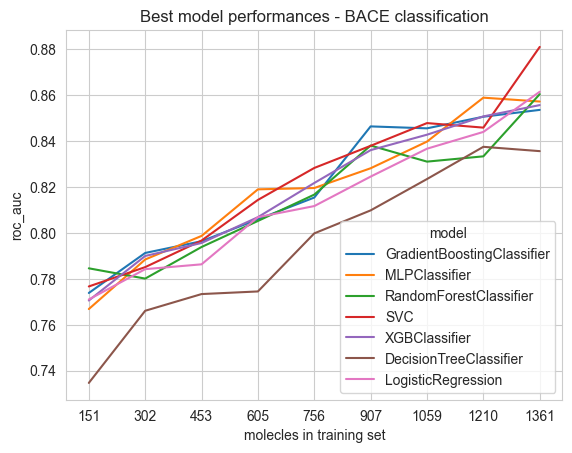

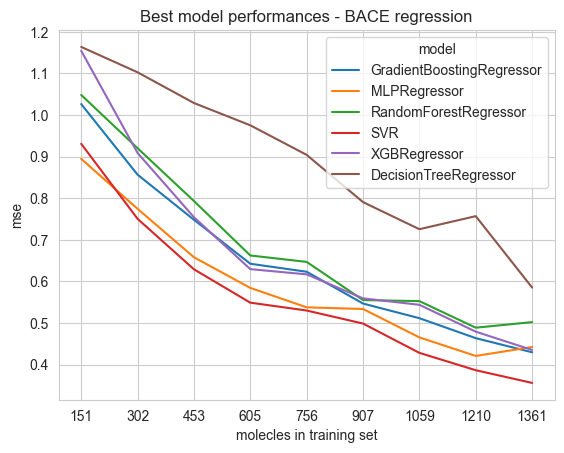

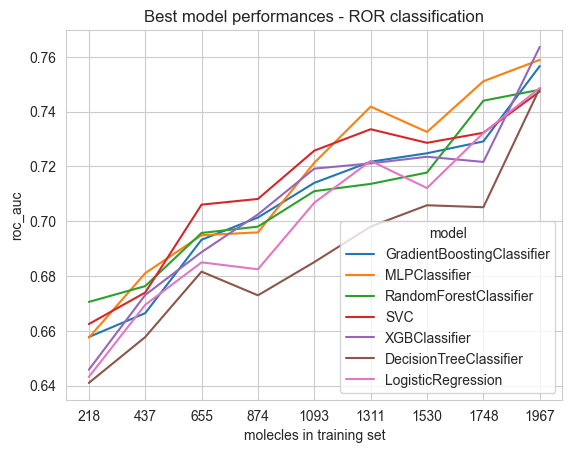

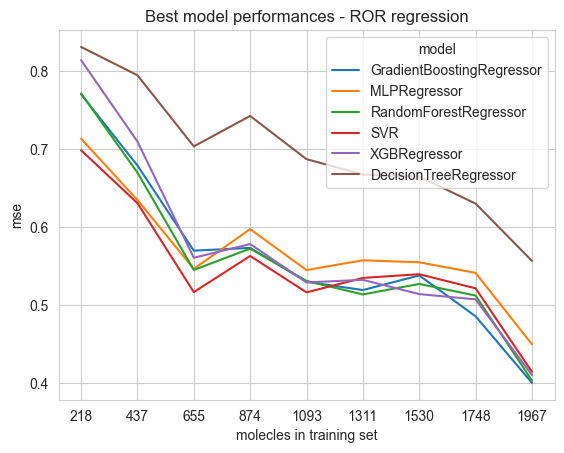

<Figure size 640x480 with 0 Axes>

In [186]:
for dataset_name in main_datasets:
    if dataset_name.split("_")[1] == "class":
        task = "classification"
    else:
        task = "regression"

    data = best_models_split[dataset_name]
    #mask = data[data.columns[2]] > 5
    mask = data['model'] == "LinearRegression"
    data = data[~mask]
    mask = data['model'] == "DecisionTreeClassifier"
    temp = data[mask]
    data = data[~mask]
    data = pd.concat([data, temp], ignore_index=True)
    mask = data['model'] == "DecisionTreeRegressor"
    temp = data[mask]
    data = data[~mask]
    data = pd.concat([data, temp], ignore_index=True)
    mask = data['model'] == "LogisticRegression"
    logistic = data[mask]
    data = data[~mask]
    data = pd.concat([data, logistic], ignore_index=True)

    fig = sns.lineplot(data=data, x="split", y=data.columns[2], hue="model")
    fig.set(title="Best model performances - " + dataset_name.split("_")[0] + " " + task)
    ROR_size = 2186
    BACE_size = 1513
    if dataset_name.split("_")[0] == "BACE":
        labels = data["split"].to_numpy()[:9] * BACE_size
    else:
        labels = data["split"].to_numpy()[:9] * ROR_size
    labels = np.append([0], labels)
    labels = (labels).astype(int)
    fig.set_xticklabels(labels)
    fig.set_xlabel("molecules in training set")

    plt.savefig(r"C:\Users\wojci\Documents\GitHub\czasteczkowa-inzynierka\experiments\plots\\" + dataset_name + ".png", bbox_inches='tight')
    plt.figure()

### Model comparison with average score of 5 best models

In [187]:
best_models_avg_top

,dataset,model,split,avg_top_score
62,BACE_class,DecisionTreeClassifier,0.1,0.724285
61,BACE_class,DecisionTreeClassifier,0.2,0.763446
60,BACE_class,DecisionTreeClassifier,0.3,0.763775
59,BACE_class,DecisionTreeClassifier,0.4,0.769575
58,BACE_class,DecisionTreeClassifier,0.5,0.796878
...,...,...,...,...
211,ROR_regre,XGBRegressor,0.5,0.537826
209,ROR_regre,XGBRegressor,0.6,0.541603
210,ROR_regre,XGBRegressor,0.7,0.523398
208,ROR_regre,XGBRegressor,0.8,0.517833


C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\1331135086.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(labels)
C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\1331135086.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(labels)
C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\1331135086.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(labels)
C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\1331135086.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(labels)
C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\1331135086.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(labels)
C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\1331135086.py:64: UserWarning: FixedFormatter should only be used together with Fixed

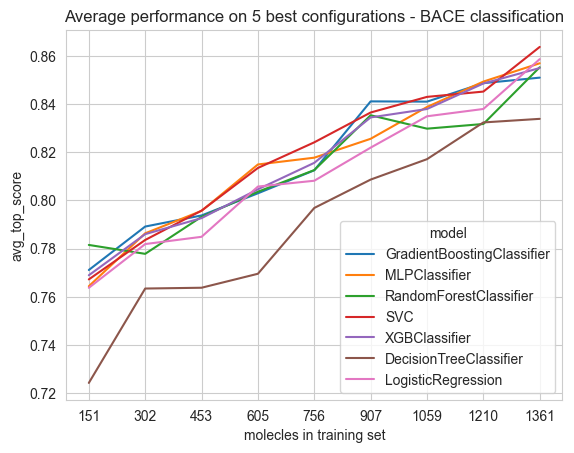

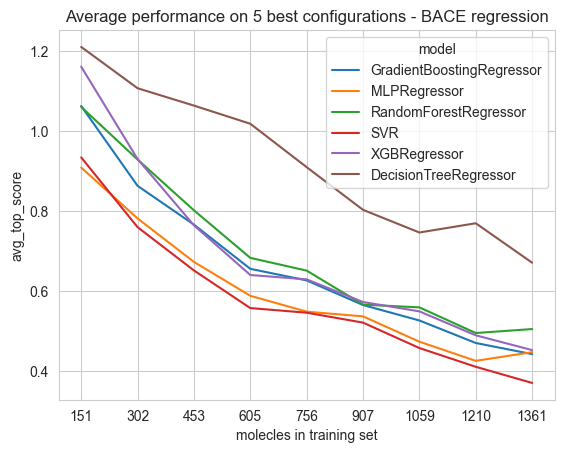

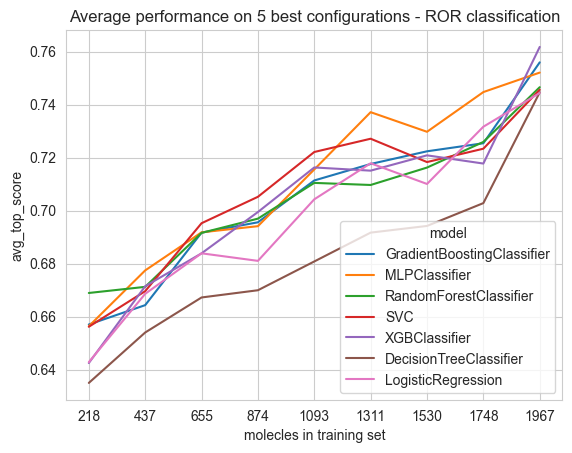

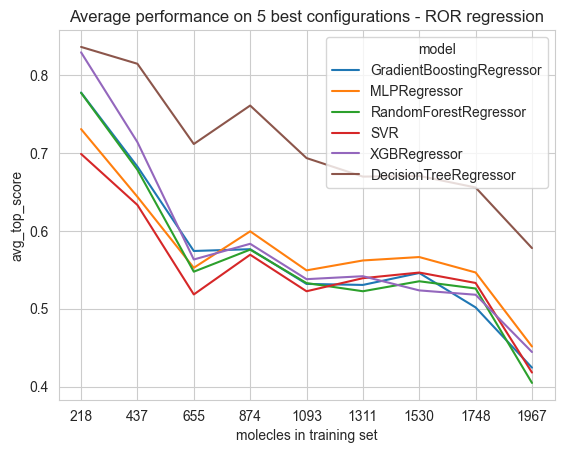

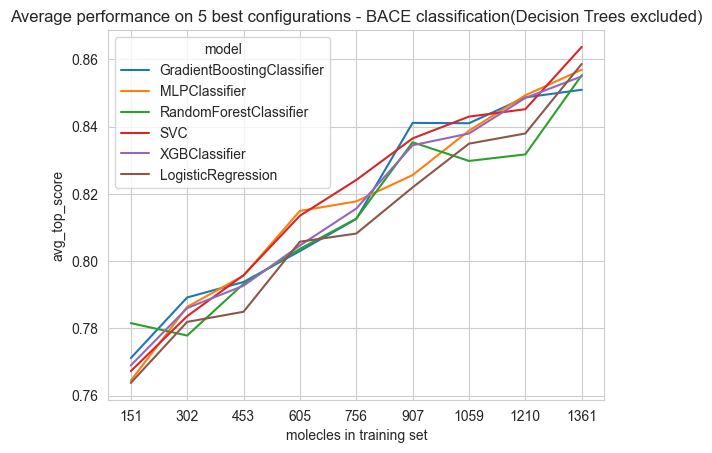

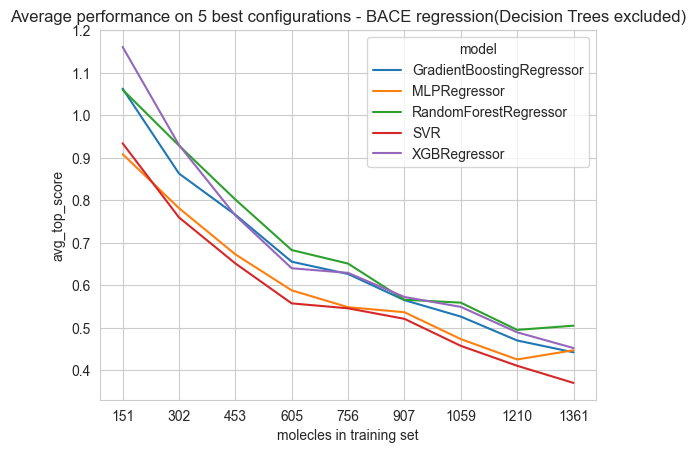

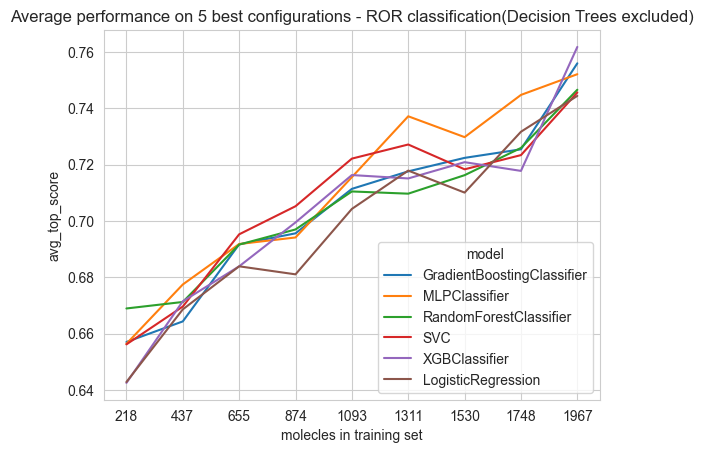

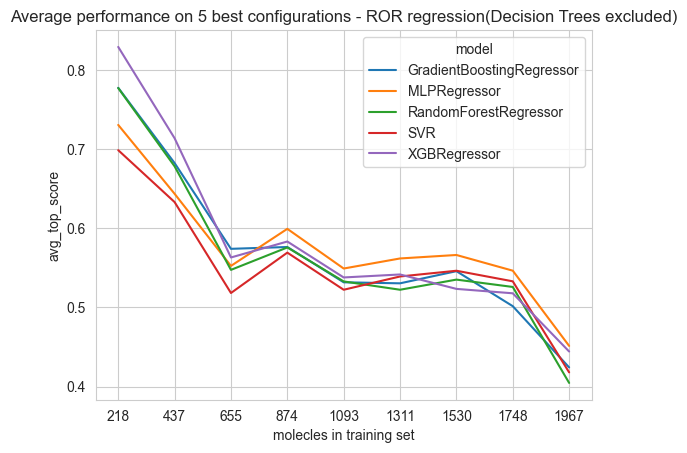

<Figure size 640x480 with 0 Axes>

In [188]:
for dataset_name in main_datasets:
    if dataset_name.split("_")[1] == "class":
        task = "classification"
    else:
        task = "regression"
    data = best_models_avg_top[best_models_avg_top["dataset"] == dataset_name]
    #mask = data[data.columns[2]] > 5
    mask = data['model'] == "LinearRegression"
    data = data[~mask]
    mask = data['model'] == "DecisionTreeClassifier"
    temp = data[mask]
    data = data[~mask]
    data = pd.concat([data, temp], ignore_index=True)
    mask = data['model'] == "DecisionTreeRegressor"
    temp = data[mask]
    data = data[~mask]
    data = pd.concat([data, temp], ignore_index=True)
    mask = data['model'] == "LogisticRegression"
    logistic = data[mask]
    data = data[~mask]
    data = pd.concat([data, logistic], ignore_index=True)
    fig = sns.lineplot(data=data, x="split", y=data.columns[3], hue="model")
    fig.set(title="Average performance on " + str(avg_top_count) + " best configurations - " + dataset_name.split("_")[0] + " " + task)
    ROR_size = 2186
    BACE_size = 1513
    if dataset_name.split("_")[0] == "BACE":
        labels = data["split"].to_numpy()[:9] * BACE_size
    else:
        labels = data["split"].to_numpy()[:9] * ROR_size
    labels = np.append([0], labels)
    labels = (labels).astype(int)
    fig.set_xticklabels(labels)
    fig.set_xlabel("molecules in training set")
    plt.savefig(r"C:\Users\wojci\Documents\GitHub\czasteczkowa-inzynierka\experiments\plots\\" + dataset_name + "_avg_top_" + str(avg_top_count) + ".png")
    plt.figure()

for dataset_name in main_datasets:
    if dataset_name.split("_")[1] == "class":
        task = "classification"
    else:
        task = "regression"
    data = best_models_avg_top[best_models_avg_top["dataset"] == dataset_name]
    #mask = data[data.columns[2]] > 5
    mask = data['model'] == "LinearRegression"
    data = data[~mask]
    mask = data['model'] == "DecisionTreeClassifier"
    data = data[~mask]
    mask = data['model'] == "DecisionTreeRegressor"
    data = data[~mask]
    mask = data['model'] == "LogisticRegression"
    logistic = data[mask]
    data = data[~mask]
    data = pd.concat([data, logistic], ignore_index=True)
    fig = sns.lineplot(data=data, x="split", y=data.columns[3], hue="model")
    fig.set(title="Average performance on " + str(avg_top_count) + " best configurations - " + dataset_name.split("_")[0] + " " + task + "(Decision Trees excluded)")
    ROR_size = 2186
    BACE_size = 1513
    if dataset_name.split("_")[0] == "BACE":
        labels = data["split"].to_numpy()[:9] * BACE_size
    else:
        labels = data["split"].to_numpy()[:9] * ROR_size
    labels = np.append([0], labels)
    labels = (labels).astype(int)
    fig.set_xticklabels(labels)
    fig.set_xlabel("molecules in training set")
    plt.savefig(r"C:\Users\wojci\Documents\GitHub\czasteczkowa-inzynierka\experiments\plots\\treeless\\" + dataset_name + "_avg_top_" + str(avg_top_count) + "_treeless.png", bbox_inches='tight')
    plt.figure()

### Hyperparameter importance (how ofted do they appear in top 5 configurations)

C:\Users\wojci\AppData\Local\Temp\ipykernel_19220\2807355888.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


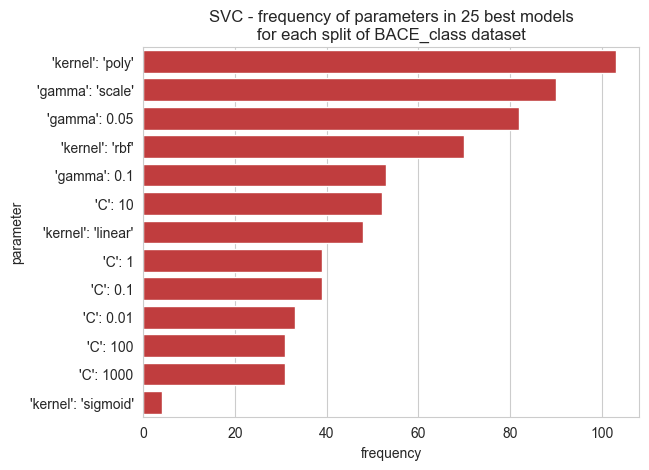

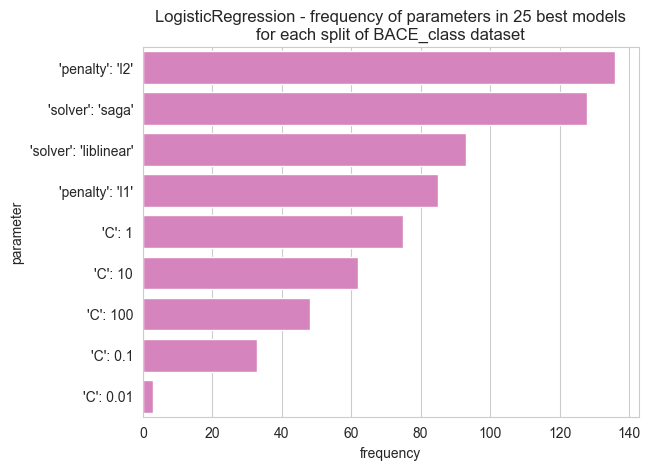

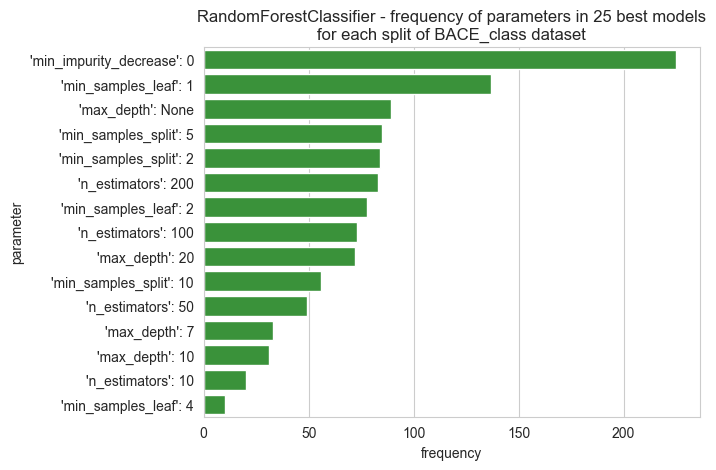

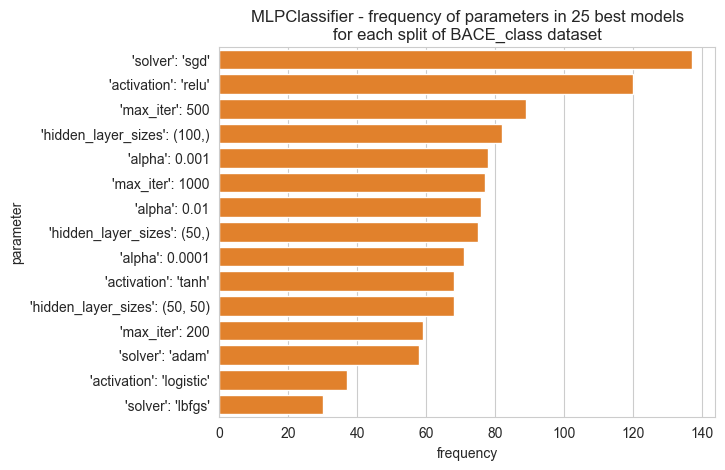

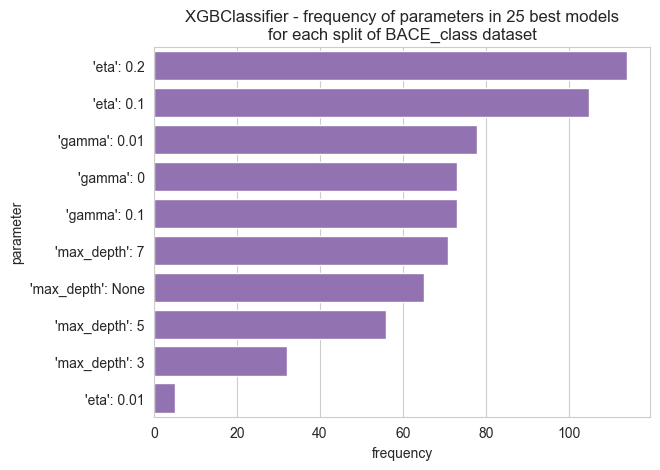

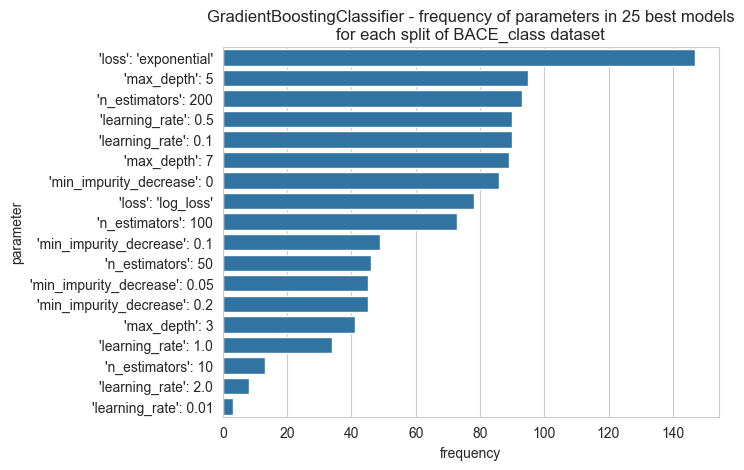

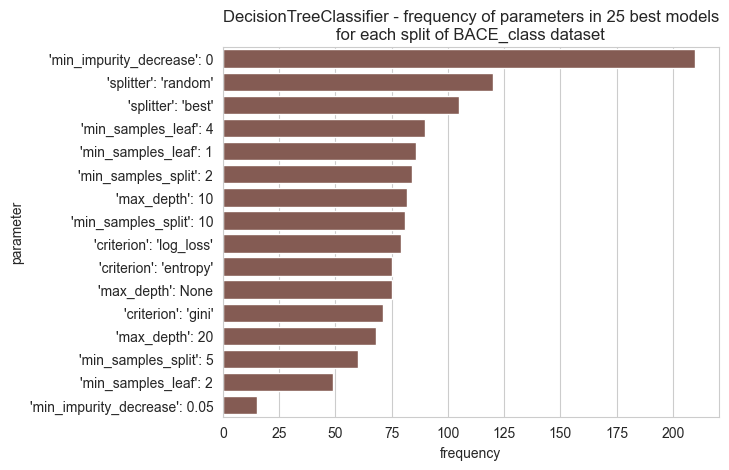

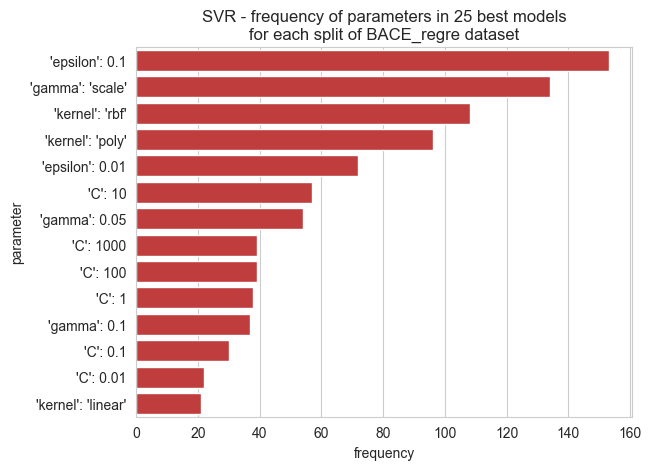

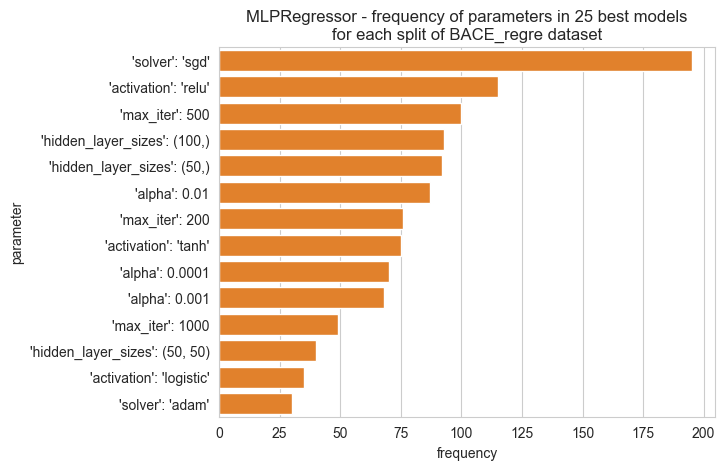

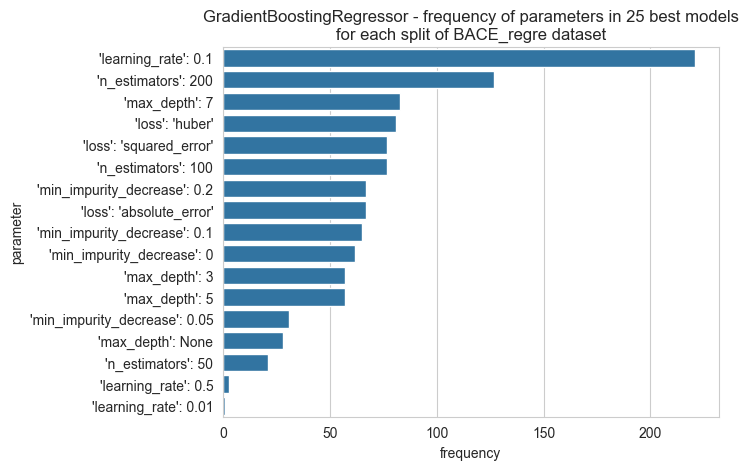

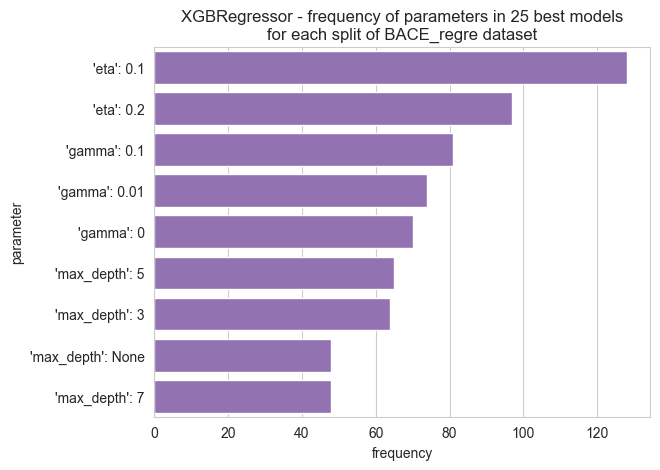

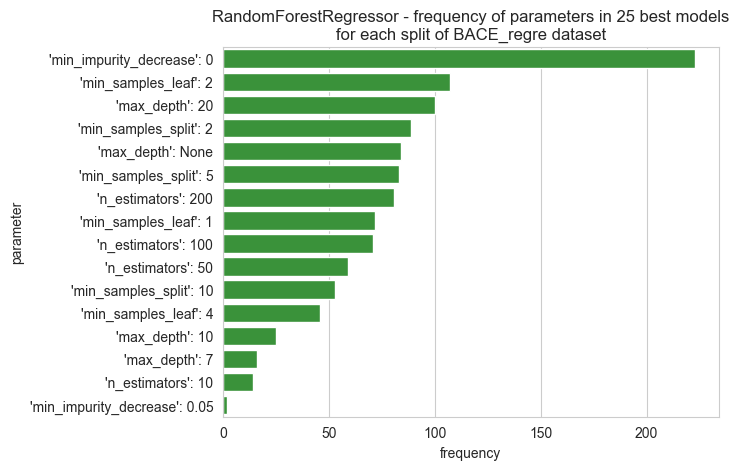

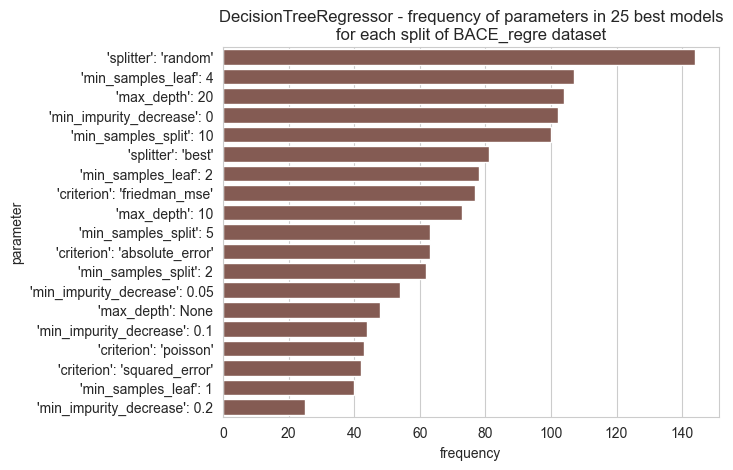

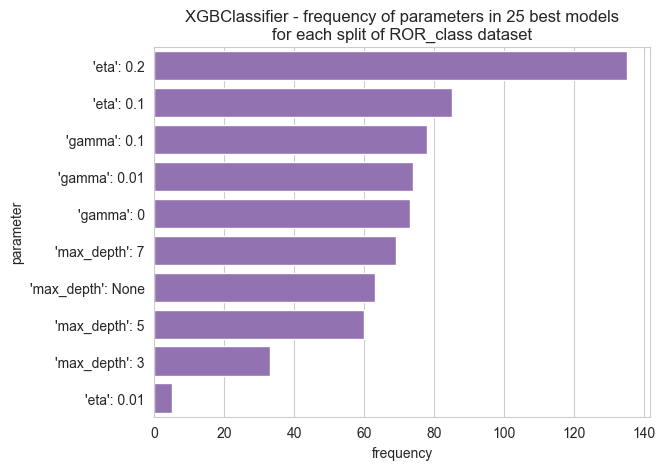

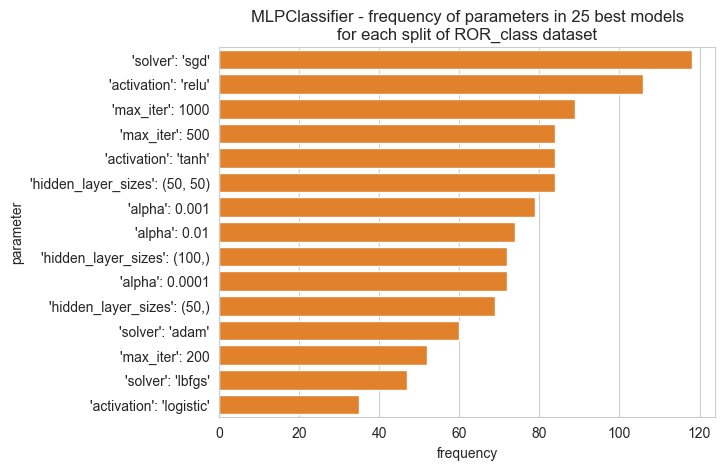

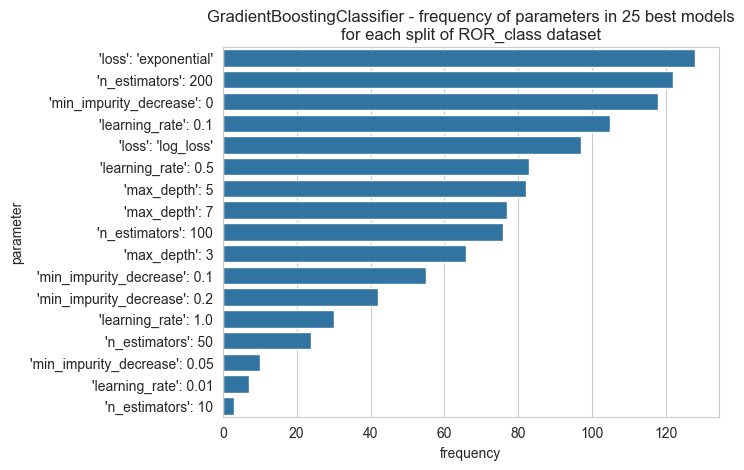

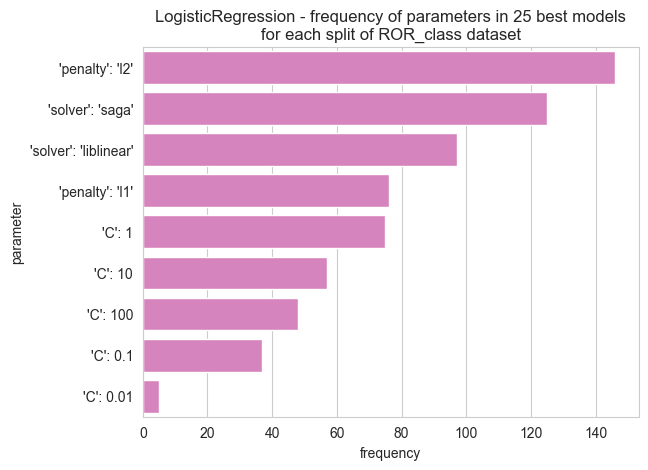

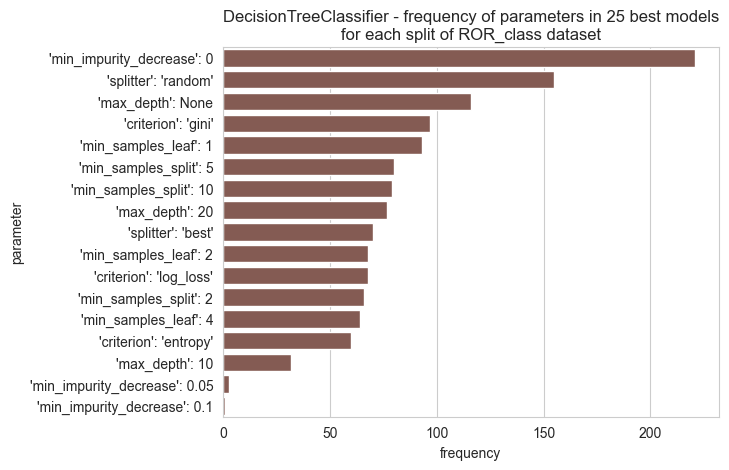

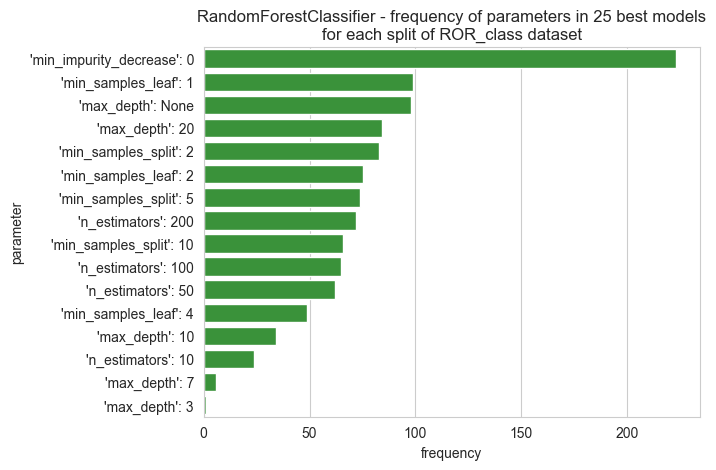

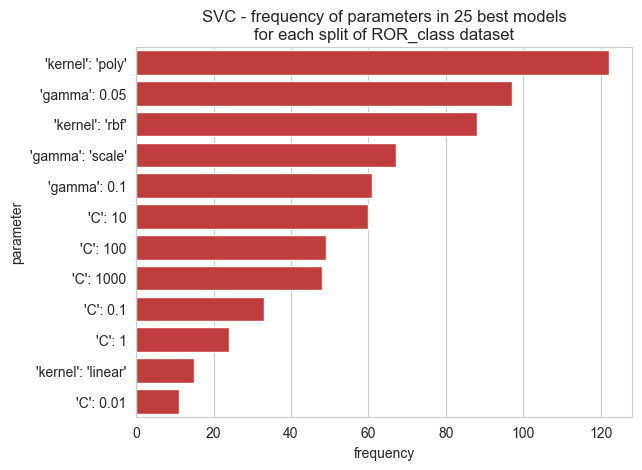

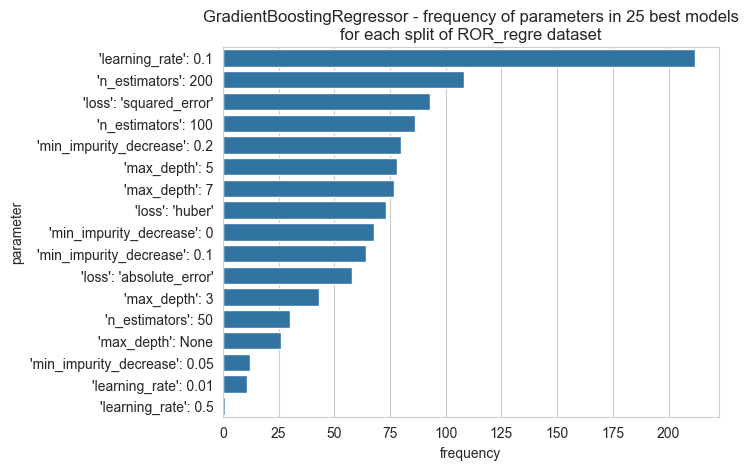

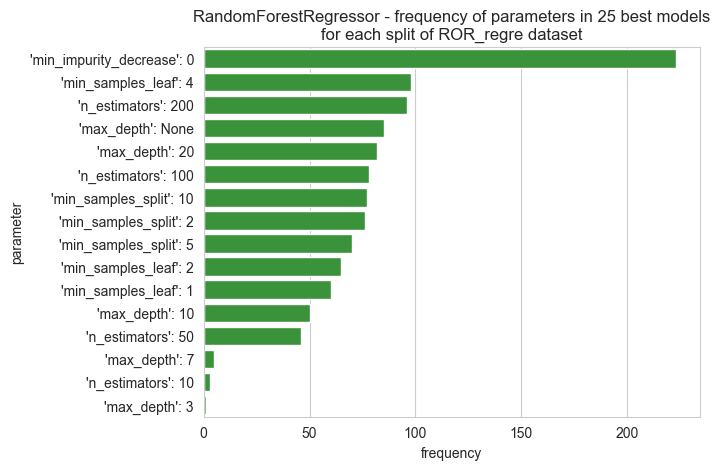

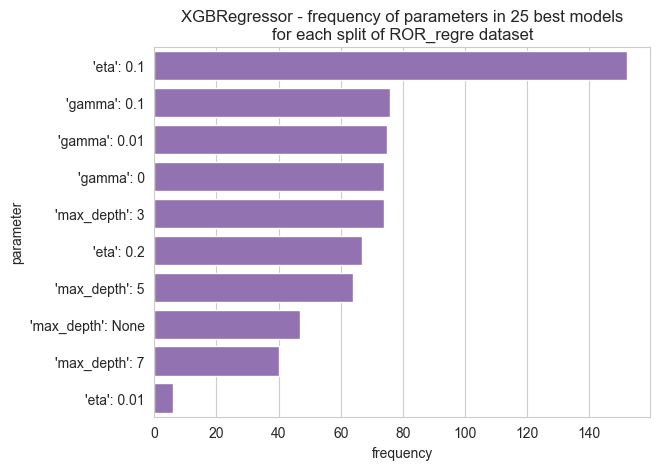

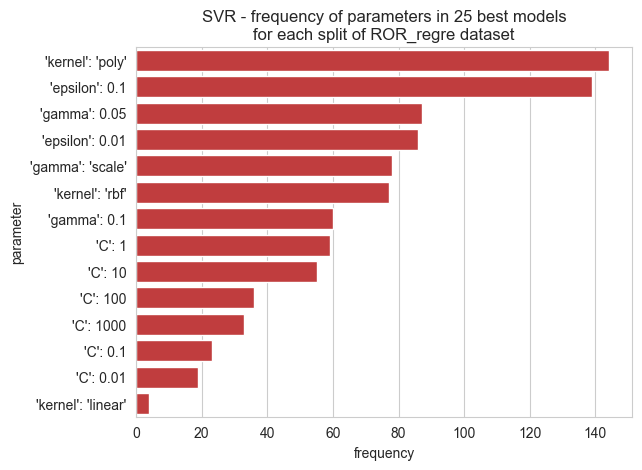

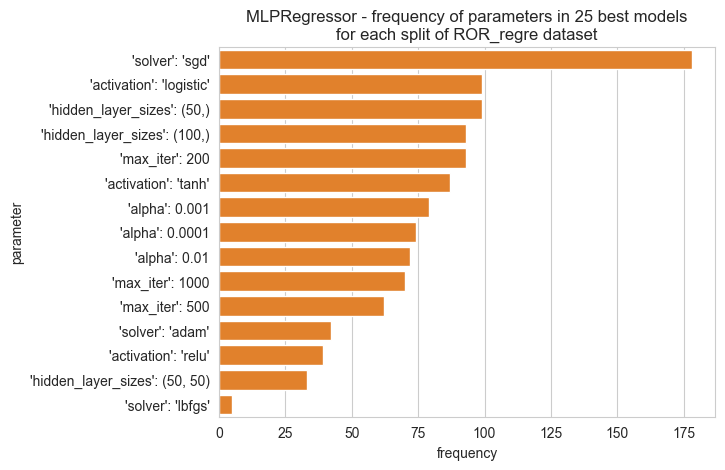

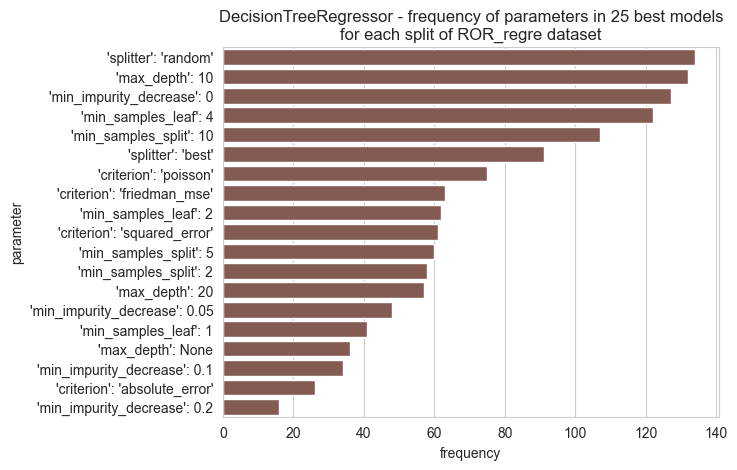

<Figure size 640x480 with 0 Axes>

In [189]:
colordict = {"DecisionTreeRegressor": "C5", "DecisionTreeClassifier": "C5", 
                    "RandomForestRegressor": "C2", "RandomForestClassifier": "C2", 
                    "LinearRegression": "C6", "LogisticRegression": "C6", 
                    "MLPRegressor": "C1", "MLPClassifier": "C1",  
                    "GradientBoostingRegressor": "C0", "GradientBoostingClassifier": "C0",
                    "XGBRegressor": "C4", "XGBClassifier": "C4", 
                    "SVR": "C3", "SVC": "C3"}

for dataset in main_datasets:
    if dataset.split("_")[1] == "class":
        task = "classification"
    else:
        task = "regression"
    for mlp in ['MLPClassifier', 'MLPRegressor']:

        if not mlp in hyperparameter_rank[dataset].keys(): continue

        hyperparameter_rank[dataset][mlp]["'hidden_layer_sizes': (50, 50)"] = hyperparameter_rank[dataset][mlp]["'hidden_layer_sizes': (50"]
        hyperparameter_rank[dataset][mlp].pop("'hidden_layer_sizes': (50")
        hyperparameter_rank[dataset][mlp].pop("50)")


    for key, items in hyperparameter_rank[dataset].items():
        hyperparameter_rank[dataset][key] = sorted(items.items(), key=lambda x: x[1], reverse=True)

    parameter_df = pd.DataFrame(columns=["model", "parameter", "frequency"])
    parameter_df.sort_values(['model', 'parameter'], inplace=True)
    for model, parameters in hyperparameter_rank[dataset].items():
        for parameter in parameters:
            parameter_df.loc[len(parameter_df.index)] = [model, parameter[0], parameter[1]]
    for model in parameter_df['model'].unique():
        mask = parameter_df['model'] == model
        data = parameter_df[mask]
        color = colordict[model]
        sns.barplot(data=data, y="parameter", x="frequency", orient="h", color=color).set(title=model + " - frequency of parameters in " + str(top_models_evaluated) + " best models\nfor each split of " + dataset + " dataset")
        #plt.xticks(rotation=90)
        plt.savefig(r"C:\Users\wojci\Documents\GitHub\czasteczkowa-inzynierka\experiments\plots\\param_freq_" + model + "_" + dataset + ".png", dpi=199, bbox_inches='tight')
        plt.figure()

### 